# Construct VWAP Profile

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn import linear_model as linear_model
import numpy as np
import pandas as pd
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

matplotlib.rcParams['figure.figsize'] = (14, 6)

In [2]:
tick_data=pd.read_csv("TSLA20200101_0115.csv")
tick_data["TIME_M"]
tick_data["DATE"]=tick_data["DATE"].map(lambda x: "/".join([str(x)[:4],str(x)[4:6],str(x)[6:]]))
tick_data.index=pd.to_datetime(tick_data["DATE"]+"/"+tick_data["TIME_M"],infer_datetime_format=True)

In [6]:
# 09:30 - 16:10
tick_data=tick_data[tick_data.index.hour<16]
tick_data=tick_data[(tick_data.index.hour*60+tick_data.index.minute)>=(9*60+30)]
tick_data=tick_data[:"20200114"]
tick_data.drop(["DATE","TIME_M"],axis=1)

,EX,SYM_ROOT,SYM_SUFFIX,SIZE,PRICE,minute_bars
2020-01-02 09:30:00.041530,P,TSLA,NaN,13,424.95,0
2020-01-02 09:30:00.041530,P,TSLA,NaN,13,424.95,0
2020-01-02 09:30:00.136327,K,TSLA,NaN,68,424.50,0
2020-01-02 09:30:00.136331,Q,TSLA,NaN,3,424.61,0
2020-01-02 09:30:00.136335,Q,TSLA,NaN,20,424.60,0
...,...,...,...,...,...,...
2020-01-14 15:59:59.381759,K,TSLA,NaN,100,537.90,389
2020-01-14 15:59:59.390833,D,TSLA,NaN,1,537.80,389
2020-01-14 15:59:59.791610,Q,TSLA,NaN,200,537.98,389
2020-01-14 15:59:59.791614,Q,TSLA,NaN,300,538.00,389


In [7]:
# add a minute bin
# US start of date, calc in minutes
start_of_day = (9 * 60) + 30
# get the time for each bin in minutes and subtract 9:30
tick_data[ 'minute_bars' ] = (tick_data.index.hour * 60) + tick_data.index.minute - start_of_day

# aggregate by minute bin
minute_bar_data = tick_data.groupby( [ tick_data.index.date,tick_data.minute_bars ] ).sum()
minute_bar_data.reset_index(level=1,inplace=True)
minute_bar_data.index=pd.to_datetime(minute_bar_data.index)

# # calculate the cumulative pct by day
minute_bar_data[ 'accum_volume' ] = minute_bar_data.groupby( [ minute_bar_data.index.date ] ).cumsum()[ 'SIZE' ]
minute_bar_data[ 'accum_pct' ] = minute_bar_data.groupby( [ minute_bar_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )
minute_bar_data

,minute_bars,SYM_SUFFIX,SIZE,PRICE,accum_volume,accum_pct
2020-01-02,0,0.0,466937,1.102473e+06,466937,0.051232
2020-01-02,1,0.0,121062,6.788148e+05,587999,0.064515
2020-01-02,2,0.0,89229,5.165818e+05,677228,0.074305
2020-01-02,3,0.0,112727,6.810832e+05,789955,0.086673
2020-01-02,4,0.0,101787,5.535854e+05,891742,0.097841
...,...,...,...,...,...,...
2020-01-14,385,0.0,77259,5.426236e+05,26665087,0.984666
2020-01-14,386,0.0,85453,6.226578e+05,26750540,0.987822
2020-01-14,387,0.0,79337,5.601427e+05,26829877,0.990752
2020-01-14,388,0.0,114244,7.708106e+05,26944121,0.994970


In [8]:
# arrange our data
minute_bars = minute_bar_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = minute_bar_data[ 'accum_pct' ]

In [9]:
# now do the regression with no intercept
lm = linear_model.LinearRegression( fit_intercept = False )
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9497868560167702

In [10]:
# coefficients
lm.coef_

array([ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09,
        1.38993793e-12])

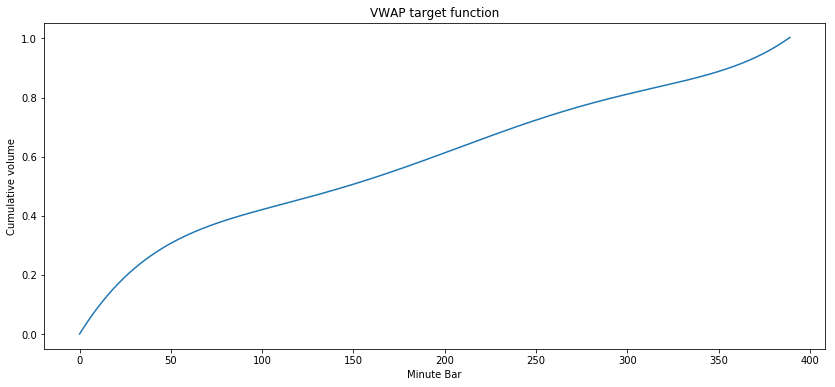

In [11]:
def vwap_target( bar_num, coefs ):
    return ( coefs[ 0 ] * bar_num + 
             coefs[ 1 ] * bar_num**2 + 
             coefs[ 2 ] * bar_num**3 +
             coefs[ 3 ] * bar_num**4 +
             coefs[ 4 ] * bar_num**5 )

bins = np.array(np.arange(0, 390),dtype="float64")
target_pct_regr = vwap_target( bins, lm.coef_ )
plt.plot(target_pct_regr,label='VWAP target function')
plt.title("VWAP target function")
plt.ylabel("Cumulative volume")
plt.xlabel("Minute Bar")
plt.show()